### Start

## 루브릭

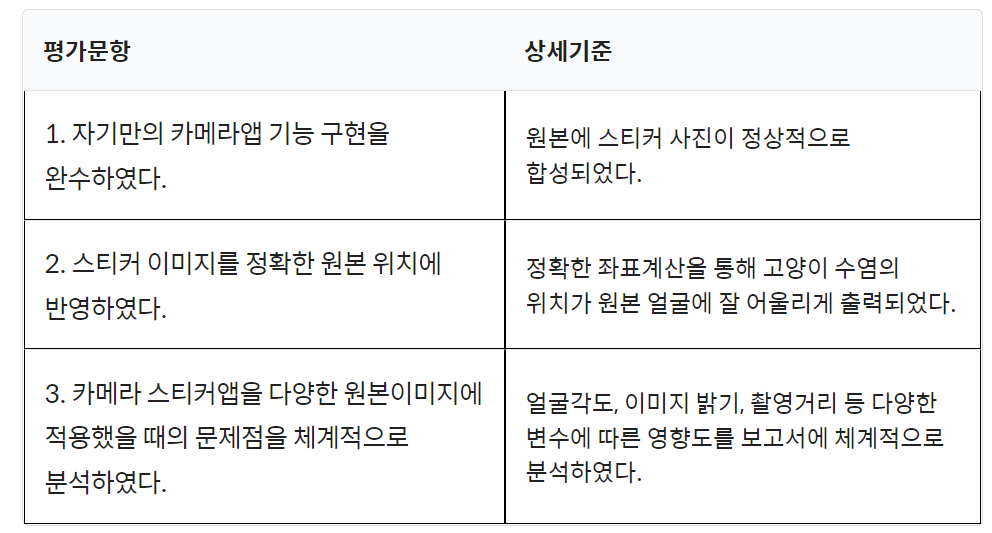

## Import

In [175]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
print(cv2.__version__)
print(dlib.__version__)

4.1.2
19.18.0


## 파일 불러오기 및 확인

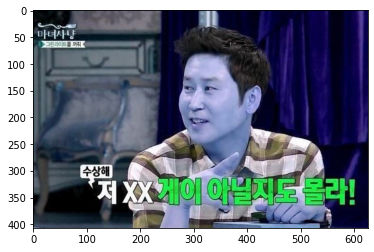

In [231]:
my_image_path = '/content/drive/MyDrive/Data/001CV/camera/image/저XX.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_bgr2 = cv2.imread(my_image_path)
img_bgr3 = cv2.imread(my_image_path)
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

In [212]:
type(img_bgr)

numpy.ndarray

## Dector 선언

In [177]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()

## BRG(open CV2) to RGB 

In [178]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

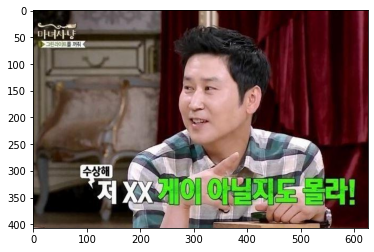

In [179]:
plt.imshow(img_rgb)
plt.show()

## BOX 영역 만들기

<Face detection rsult>


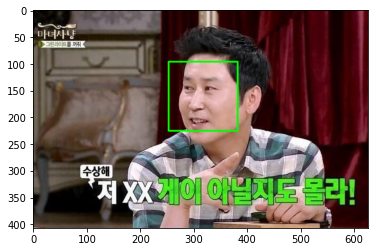

In [180]:
# HOG 얼굴 바운딩박스 탐지기 생성 및 할당
# detector_hog = dlib.get_frontal_face_detector()

#얼굴 바운딩박스 추출 - 얼굴 검출기를 이미지에 적용
# dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

# 이미지 피라미드? - 이미지를 upsampling해서 크기를 키우는 것
# 작게 촬영된 얼굴을 크게 보게 만드는것 - 정확한 검출 가능


# 찾은 얼굴 영역 좌표 
for dlib_rect in dlib_rects: 
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
print("<Face detection rsult>")
plt.imshow(img_show_rgb)
plt.show()

## model path, import

In [181]:
model_path = '/content/drive/MyDrive/Data/001CV/camera/model/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

## 랜드마크 탐색

In [182]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


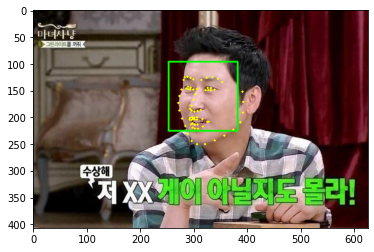

In [183]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 코 위치 계산

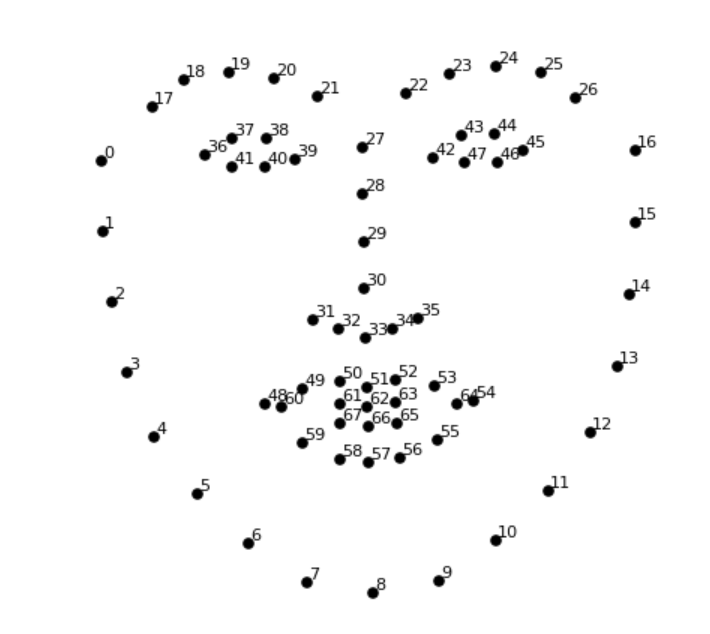

In [185]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    nose_x = landmark[30][0]
    nose_y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('코의 좌표(x,y) : (%d,%d)'%(nose_x,nose_y))
    print ('스티커의 크기(w,h) : (%d,%d)'%(w,h))

(296, 178)
코의 좌표(x,y) : (296,113)
스티커의 크기(w,h) : (130,130)


코[30] 위치는 (296,113)

내가 원하는 위치는 [33]~~[51] 사이

In [186]:
lips_x = landmark[51][0]
lips_y = landmark[51][1] - dlib_rect.height()//2
print ('입술 위쪽의 좌표(x,y) : (%d,%d)'%(lips_x,lips_y))

입술 위쪽의 좌표(x,y) : (301,136)


입술 위쪽의 좌표는 (301,136), 코 중앙의 좌표는 (296,113) 이므로 그 사이를 계산. 

## 수염 좌표

In [187]:
p_x = (lips_x - nose_x)//2 + nose_x
p_y = (lips_y - nose_y)//2 + nose_y
print ('수염 좌표(x,y) : (%d,%d)'%(p_x,p_y))

수염 좌표(x,y) : (298,124)


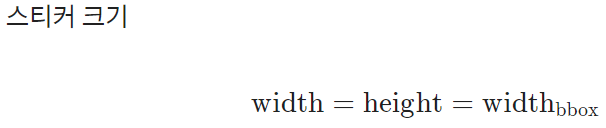

스티커의 크기는 (130,130)

## 스티커 불러오기

(130, 130, 3)


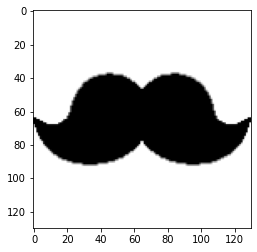

In [188]:
sticker_path = '/content/drive/MyDrive/Data/001CV/camera/image/mustache.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 리사이즈

plt.imshow(img_sticker)
print (img_sticker.shape)

## x,y 좌표 조정

수염 좌표(x,y) : (298,124)

이미지 시작점은 왼쪽 위 좌표 (0,0)

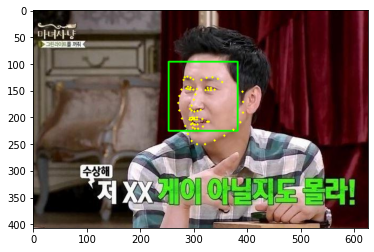

In [189]:
# 수염의 중앙 좌표 정의

In [190]:
refined_x = p_x - h//2 
refined_y = p_y     
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (233,124)


In [191]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
    
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (233,124)


## 사진 출력

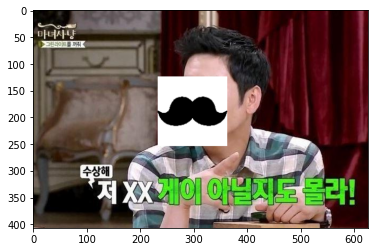

In [219]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==(0),sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 충격적인 결과!

원하던 대로 수염만 나오는 것이 아닌 배경까지 같이 나왔다.

## 오류 수정

(130, 130, 3)


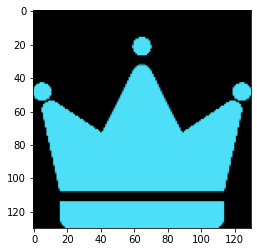

In [213]:
sticker_path = '/content/drive/MyDrive/Data/001CV/camera/image/king.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
plt.imshow(img_sticker)
print (img_sticker.shape)

(130, 130, 3)


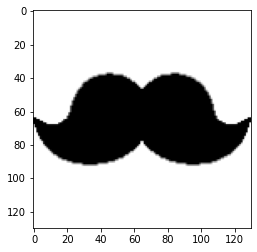

In [214]:
sticker_path = '/content/drive/MyDrive/Data/001CV/camera/image/mustache.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 리사이즈

plt.imshow(img_sticker)
print (img_sticker.shape)

두 스티커 이미지에서 매우 큰 차이가 발견되었다.

왕관모양 스티커는 이미지를 출력했을 때 BRG값으로 나오는데 반해, 수염모양 스티커는 RGB값으로 나오기 때문이다.

따라서 BRG와 RGB출력의 차이를 알아야 원래대로 돌릴 수 있을것이다.

In [217]:
print(img_sticker)

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


딱 보니 수염 스티커의 첫 행은 흰색을 나타내는 코드일 것이고 이것이 RGB색상으로 나타냈을 때는 다음 그림과 같이 흰색을 나타내게 된다.

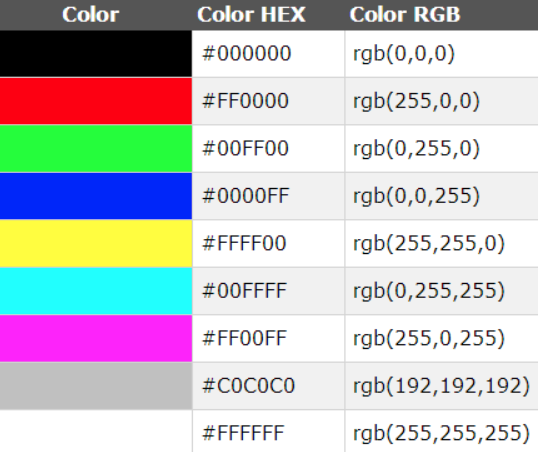

따라서 스티커에서 np.where메서드로 출력에서 제외할 색의 값은 (255,255,255)이 되는 것이다.

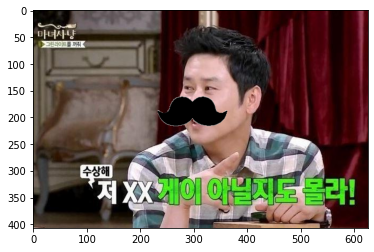

In [224]:
sticker_area = img_bgr2[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr2[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==(255,255,255),sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB))
plt.show()

# 유레카!

성공했다! 하지만 조금 아쉬운점은 수염 스티커는 이보다 더 작으면 잘 어울렸을 것이라는 점이다.

In [225]:
w1 = h1 = 70

(70, 70, 3)


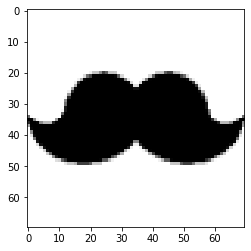

In [226]:
sticker_path = '/content/drive/MyDrive/Data/001CV/camera/image/mustache.png'
img_sticker2 = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker2 = cv2.resize(img_sticker, (w1,h1)) # 스티커 이미지 리사이즈

plt.imshow(img_sticker2)
print (img_sticker2.shape)

그림판으로 어림잡아 점의 위치를 추정해보면 (35,30)정도인듯 하다.

In [280]:
#최적의 위치를 직접 수정함
refined_x2 = p_x - w1//2
refined_y2 = p_y + 37
print ('(x,y) : (%d,%d)'%(refined_x2, refined_y2))

(x,y) : (263,161)


In [278]:
img_bgr3 = cv2.imread(my_image_path) 

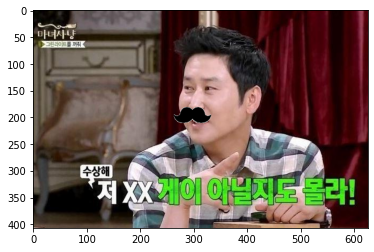

In [279]:
sticker_area = img_bgr3[refined_y2:refined_y2 +img_sticker2.shape[0], refined_x2:refined_x2+img_sticker2.shape[1]]

img_bgr3[refined_y2:refined_y2 +img_sticker2.shape[0], refined_x2:refined_x2+img_sticker2.shape[1]] = \
    np.where(img_sticker2==(255,255,255),sticker_area,img_sticker2).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr3, cv2.COLOR_BGR2RGB))
plt.show()

작은 수염이 더 잘 어울린다!

# 회고

이번 노드에서는 Open CV를 사용하여 원본이미지에 다른 이미지를 씌우는 작업을 했다.

박스 영역이라던가 랜드마크들은 이미 다 모델이 제공되어 있어 편했다.

다만 이번에는 조금 귀찮은 작업인 좌표를 계산하는 작업이 있어 살짝 짜증을 유발했다.

또한 막상 이미지를 덧씌워도, 덧씌운 이미지에 배경이 존재했기때문에 의도한 대로 씌워지지 않았다.

따라서 rgb 코드표를 찾아서 흰색 배경을 찾아 제거했다.

이때 드는 의문은 흰색 배경이 아닌, 실제 배경을 제거하려면 어떻게 하게 되는 것인지 궁금했다.

이를 검색해보니 이미 누군가가 만들어둔 코드가 있었고 open CV로 실행할 수 있었다.

In [303]:
# 이미지 로드 후 RGB로 변환
image_bgr_x = cv2.imread('/content/drive/MyDrive/Data/001CV/camera/image/신동엽.png')
image_rgb_x = cv2.cvtColor(image_bgr_x, cv2.COLOR_BGR2RGB)

In [308]:
image_rgb_x.shape

(279, 349, 3)

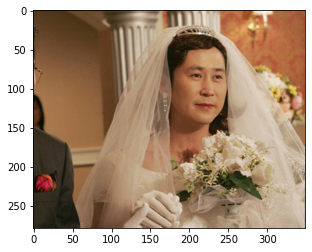

In [307]:
plt.imshow(image_rgb_x)
plt.show()

In [313]:
# 사각형 좌표: 시작점의 x,y  ,넢이, 너비
rectangle = (20, 60, 240, 290)

# 초기 마스크 생성
mask = np.zeros(image_rgb_x.shape[:2], np.uint8)

# grabCut에 사용할 임시 배열 생성
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# grabCut 실행
cv2.grabCut(image_rgb_x, # 원본 이미지
           mask,       # 마스크
           rectangle,  # 사각형
           bgdModel,   # 배경을 위한 임시 배열
           fgdModel,   # 전경을 위한 임시 배열 
           5,          # 반복 횟수
           cv2.GC_INIT_WITH_RECT) # 사각형을 위한 초기화

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[1.24274562e-01, 2.24690274e-01, 2.86635477e-01, 1.72115741e-01,
         1.92283946e-01, 4.64587105e+01, 3.88202694e+01, 2.50133584e+01,
         2.05716676e+02, 1.87961287e+02, 1.65708433e+02, 1.65867174e+02,
         1.06694428e+02, 6.78448210e+01, 1.82750259e+02, 1.52292228e+02,
         1.16772738e+02, 9.85029611e+01, 6.72488762e+01, 3.89043882e+01,
         2.74522086e+02, 1.95863632e+02, 1.79851567e+02, 1.95863632e+02,
         1.66713336e+02, 1.55829184e+02, 1.79851567e+02, 1.55829184e+02,
         1.63604922e+02, 1.26390754e+02, 1.44993611e+02, 1.81527455e+02,
         1.44993611e+02, 1.72790954e+02, 2.16472379e+02, 1.81527455e+02,
         2.16472379e+02, 2.87857774e+02, 3.91262512e+02, 1.80555430e+02,
         1.14399405e+02, 1.80555430e+02, 2.8

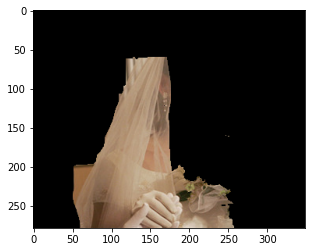

In [314]:
# 배경인 곳은 0, 그 외에는 1로 설정한 마스크 생성
mask_2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')

# 이미지에 새로운 마스크를 곱행 배경을 제외
image_rgb_nobg = image_rgb_x * mask_2[:, :, np.newaxis]

# plot
plt.imshow(image_rgb_nobg)
plt.show()

생각보다 잘 안된다.. 아직 뭘 어떻게 사용하는지 잘 모르겠으니 나중에 시도해보는게 좋을거 같다.

아무튼 결과적으로 스티커 사진 자체는 잘 만들어 졌다.

위에서 사용한 웨딩드레스를 입은 신동엽의 짤은 사실 처음에 스티커사진의 원본 이미지로 사용하려 했었다. 그러나 머리에 쓴 베일 때문인지 얼굴을 인식하지 못했고,
결국엔 다른 이미지로 교체해서 얼굴인식을 통해 스티커 사진을 완성했다.

생각보다 모델이 엄청 강력하지는 않다는 사실을 깨달았고, 아마 얼굴 주변에 무언가가 있기만 해도 얼굴 인식이 매우 힘들 것이다.

그리고 얼굴 각도에 따라서 스티커도 각도를 바꿔줘야 할텐데, 이는 좌표변환에 관련될것 같고, 그걸 계산하기는 너무 귀찮아서 pass..